# Calculations of the finger movement speeds

In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import ast
import os
import matplotlib.patches as mpatches
import itertools
from pandarallel import pandarallel
pandarallel.initialize()

INFO: Pandarallel will run on 96 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## Movement speeds in different conditions, for different fingers and phones

In [2]:
task_length_df = pd.read_csv("./out/tasklengths.csv", sep = ";")
task_length_df["Tasks"] = task_length_df["Tasks"].apply(ast.literal_eval)
task_length_df["TaskLengths"] = task_length_df["TaskLengths"].apply(ast.literal_eval)

lst = []

fingers = ["Thumb", "Index", "Middle", "Ring", "Little"]
tasks = ["READ", "WRITE", "Fitts"]
j = "Fn"

def sqrt_sum(x,y):
    x_0 = x[0]
    y_0 = y[0]
    dist = 0
    for x_1, y_1 in zip(x[1:],y[1:]):
        a = np.array([x_0,y_0])
        b = np.array([x_1,y_1])
        dist += np.sqrt(np.sum((a-b)**2, axis=0))
        x_0 = x_1
        y_0 = y_1
        
    return dist

def readStudyFile(file_path):
    lst = []
    pid, phone, cond = file_path.split("/")[-1].replace(".pkl","")[1:].split("_")
    pid = int(pid)
    print("Reading %s %i %s %s" % (file_path, pid, phone, cond))
        
    df = pd.read_pickle(file_path)
    df = df[::2]
    task_times = None
    tasklength_row = task_length_df[(task_length_df["Participant"]==pid)&(task_length_df["Phone"]==phone)&(task_length_df["Cond"]==cond)]
    
    if len(tasklength_row) == 0:
        print("None tasklength_row file: %s" % file_path)
        return None
    
    for index,row in tasklength_row.iterrows():
        task_sequence = row["Tasks"]
        task_times = row['TaskLengths']
    
    if task_times is None:
        print("None task_times file: %s" % file_path)
        return None
    
    for task in tasks:   
        tasktime = task_times[task_sequence.index(task)]
        
        for f in fingers:
            temp_df = df[df["Task"] == task].copy()
            
            help_dict = {"Participant":pid, "Phone":phone, "Cond":cond}
            help_dict["Task"] = task
            help_dict["TaskLength"] = tasktime
            
            a=(temp_df["%s_%s_X"%(f,j)]>temp_df["%s_%s_X"%(f,j)].mean()-temp_df["%s_%s_X"%(f,j)].std()*2)&\
            (temp_df["%s_%s_X"%(f,j)]<temp_df["%s_%s_X"%(f,j)].mean()+temp_df["%s_%s_X"%(f,j)].std()*2)&\
            (temp_df["%s_%s_Y"%(f,j)]>temp_df["%s_%s_Y"%(f,j)].mean()-temp_df["%s_%s_Y"%(f,j)].std()*2)&\
            (temp_df["%s_%s_Y"%(f,j)]<temp_df["%s_%s_Y"%(f,j)].mean()+temp_df["%s_%s_Y"%(f,j)].std()*2)


            t = temp_df[a]["Time"]-temp_df.shift()[a]["Time"]
            val = 20
            x = temp_df[a]["%s_%s_X"%(f,j)]-temp_df.shift()[a]["%s_%s_X"%(f,j)]
            x = x[x.index.isin(t[t<=val].index)]

            y = temp_df[a]["%s_%s_Y"%(f,j)]-temp_df.shift()[a]["%s_%s_Y"%(f,j)]
            y = y[y.index.isin(t[t<=val].index)]

            z = temp_df[a]["%s_%s_Z"%(f,j)]-temp_df.shift()[a]["%s_%s_Z"%(f,j)]
            z = z[z.index.isin(t[t<=val].index)]

            t = t[t.index.isin(t[t<=val].index)]
            #
            l = np.sqrt(np.square(x)+np.square(y))
            ql = np.sqrt(np.square(x)+np.square(y)+np.square(z))

            cmps = ((l*100)/(t/1000))
            len_before = len(cmps)
            cmps = cmps[(cmps<cmps.mean()+cmps.std()*2)&(cmps>cmps.mean()-cmps.std()*2)]
            len_after = len(cmps)
            qcmps = ((ql*100)/(t/1000))
            help_dict["Joint"]="%s_%s"%(f,j)
            help_dict["Speed_2D"] = cmps.mean()
            help_dict["2D_dropped"] = np.round((len_after/len_before),2)
            help_dict["Speed_3D"] = qcmps.mean()

            lst.append(help_dict)
    return lst


In [3]:
path = "./TransformedPickles/"
files = []
for file in os.listdir(path):
    if not file.endswith(".pkl"):
        continue
    files.append(path+file)

In [4]:
%%time
dfFiles = pd.DataFrame(files)
dfFiles.columns=["File"]
ret = dfFiles.File.parallel_apply(lambda x: readStudyFile(x))
ret2 = list(itertools.chain.from_iterable(ret))
df = pd.DataFrame(ret2)

Reading ./TransformedPickles/P3_N6_walking.pkl 3 N6 walking
Reading ./TransformedPickles/P10_N6_walking.pkl 10 N6 walking
Reading ./TransformedPickles/P10_OPO_seated.pkl 10 OPO seated
Reading ./TransformedPickles/P5_S4_seated.pkl 5 S4 seated
Reading ./TransformedPickles/P16_S4_seated.pkl 16 S4 seated
Reading ./TransformedPickles/P21_OPO_walking.pkl 21 OPO walking
Reading ./TransformedPickles/P7_OPO_seated.pkl 7 OPO seated
Reading ./TransformedPickles/P5_OPO_seated.pkl 5 OPO seated
Reading ./TransformedPickles/P10_S3_seated.pkl 10 S3 seated
Reading ./TransformedPickles/P12_OPO_seated.pkl 12 OPO seated
Reading ./TransformedPickles/P14_S4_seated.pkl 14 S4 seated
Reading ./TransformedPickles/P8_OPO_seated.pkl 8 OPO seated
Reading ./TransformedPickles/P6_OPO_seated.pkl 6 OPO seated
Reading ./TransformedPickles/P20_S4_seated.pkl 20 S4 seated
Reading ./TransformedPickles/P7_N6_seated.pkl 7 N6 seated
Reading ./TransformedPickles/P11_N6_seated.pkl 11 N6 seated
Reading ./TransformedPickles/P10_S

In [5]:
f_list = ['Index_Fn', 'Middle_Fn', 'Ring_Fn', 'Little_Fn']

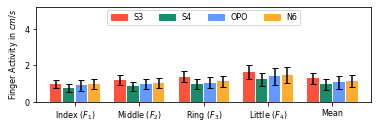

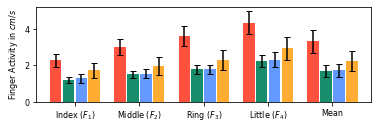

In [6]:
phones = ["S3","S4","OPO","N6"]
phone_labels = ["S3","S4","OPO","N6"]
conditions = ['seated','walking']
colors = ['#FF523E','#188D6C','#6499FF','#FFAC33']
fingers = ["Index_Fn","Middle_Fn","Ring_Fn","Little_Fn", "Mean"]
finger_labels = [r"Index ($F_1$)", r"Middle ($F_2$)", r"Ring ($F_3$)", r"Little ($F_4$)",  r"Mean"]

width = 0.2


fig = []
ax = []
for i in range(len(conditions)):
    fig1, ax1 = plt.subplots(1, figsize=(6, 1.75))
    fig.append(fig1)
    ax.append(ax1)

    
for idx_condition, condition in enumerate(conditions): 
    xticks = []
    for idx_finger, finger in enumerate(fingers):
        xticks.append(float(idx_finger) + 1.5 * width)
        
        for idx_phone, phone in enumerate(phones):
            if (finger != "Mean"):
                mean = df[(df.Joint == finger) & (df.Cond == condition) & (df.Phone == phone)].Speed_2D.mean()
                sd = df[(df.Joint == finger) & (df.Cond == condition) & (df.Phone == phone)].Speed_2D.std()
            else:
                mean = df[(df.Cond == condition) & (df.Phone == phone) & (df["Joint"].isin(f_list))].Speed_2D.mean()
                sd = df[(df.Cond == condition) & (df.Phone == phone) & (df["Joint"].isin(f_list))].Speed_2D.std()

            
            pos = idx_finger + (idx_phone * width) 
            ax[idx_condition].bar(pos, mean, yerr = sd/2, width = width - 0.02, capsize = 3, color = colors[idx_phone])

            
    fontsize = 8
    if (idx_condition == 0):
        patches = []
        for i in range(len(colors)):
            patch = mpatches.Patch(color=colors[i], label=phone_labels[i])
            patches.append(patch)
        ax[idx_condition].legend(handles= patches, ncol = 4, loc='upper center', bbox_to_anchor = (0.5, 0.97), borderaxespad=0., fontsize=fontsize) 
    
    condLbl = ["Sitting", "Walking"]
    ax[idx_condition].tick_params(axis='both', which='major', labelsize=fontsize)
    ax[idx_condition].tick_params(axis='both', which='minor', labelsize=fontsize)
          
    ax[idx_condition].set_ylabel("Finger Activity in $cm/s$", fontsize=fontsize)
    ax[idx_condition].set_xticklabels(finger_labels, fontsize=fontsize)
    ax[idx_condition].set_xticks(xticks)
    ax[idx_condition].set_xlim(-(width + 0.1), len(xticks) - (width-0.1))
    ax[idx_condition].set_ylim(0, 5.2)
    
    fig[idx_condition].savefig("./figures/finger_activity_" + condition + ".pdf", bbox_inches="tight", pad_inches=0)

In [7]:
df.groupby(["Cond", "Joint", "Participant", "Phone"]).mean().Speed_2D.reset_index().rename(columns={"Joint": "Finger", "Participant": "PId"}).to_csv("./out/speeds.csv", index=False)